In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('arrival_times.csv')
df = df.dropna(axis=0, how='any')
df.head()

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39


In [24]:
df['scheduled'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['SCH_STOP_TM'])
df['actual'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['ACT_STOP_TM'])

df.head()

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM,scheduled,actual
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19,2016-03-26 01:11:57,2016-03-26 01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13,2016-03-26 23:19:57,2016-03-26 23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46,2016-03-26 21:19:57,2016-03-26 21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49,2016-03-26 19:04:57,2016-03-26 19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39,2016-03-26 16:42:57,2016-03-26 16:42:39


In [25]:
# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (df['actual'] - df['scheduled']) / hour
df.loc[diff_hrs > 20, 'actual'] -= 24 * hour
df.loc[diff_hrs < -20, 'actual'] += 24 * hour
df['minutes_late'] = (df['actual'] - df['scheduled']) / minute
df.head()

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM,scheduled,actual,minutes_late
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000


In [26]:
# map internal route codes to external route letters
df['route'] = df['RTE'].replace({673: 'C', 674: 'D', 675: 'E'}).astype('category')
df['direction'] = df['DIR'].replace({'N': 'northbound', 'S': 'southbound'}).astype('category')

# extract useful columns
df = df[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

df.head()

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


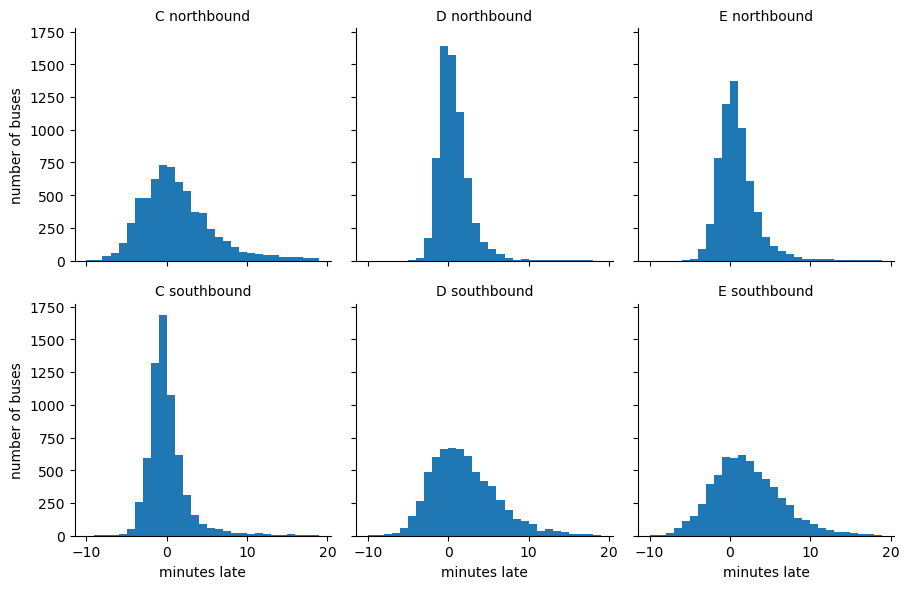

In [31]:
g = sns.FacetGrid(df, row="direction", col="route")
g.map(plt.hist, "minutes_late", bins=np.arange(-10, 20))
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('minutes late', 'number of buses');

In [41]:
##Scheduled and Observed Arrival Intervals¶
def compute_headway(scheduled):
    minute = np.timedelta64(1, 'm')
    return scheduled.sort_values().diff() / minute

grouped = df.groupby(['route', 'direction'])
#df.head()
df['actual_interval'] = grouped['actual'].transform(compute_headway)
df['scheduled_interval'] = grouped['scheduled'].transform(compute_headway)
df.head()

,route,direction,scheduled,actual,minutes_late,actual_interval,scheduled_interval
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667,37.283333,37.0
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333,12.233333,15.0
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333,13.016667,15.0
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333,11.633333,15.0
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000,11.933333,12.0


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


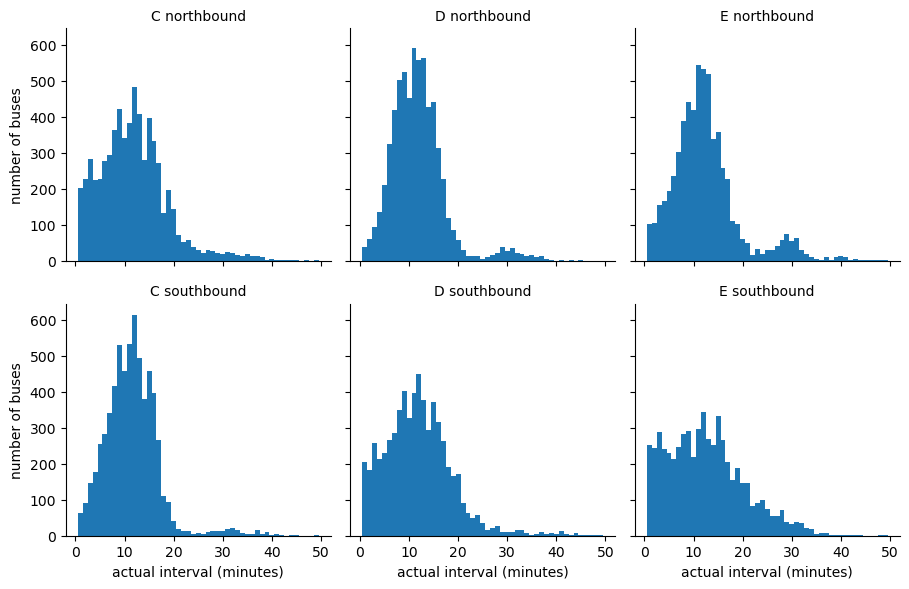

In [45]:
g = sns.FacetGrid(df.dropna(), row="direction", col="route")
g.map(plt.hist, "actual_interval", bins=np.arange(50) + 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('actual interval (minutes)', 'number of buses');

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


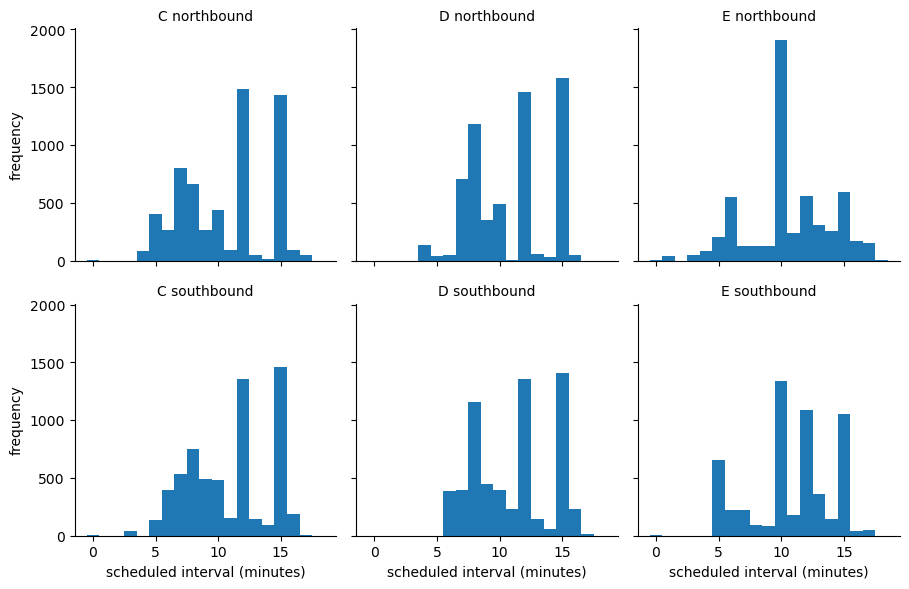

In [46]:
##Let's repeat the above chart, examining the scheduled rather than observed arrival intervals:
g = sns.FacetGrid(df.dropna(), row="direction", col="route")
g.map(plt.hist, "scheduled_interval", bins=np.arange(20) - 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('scheduled interval (minutes)', 'frequency');

##Constructing Uniform Schedules

def stack_sequence(data):
    # first, sort by scheduled time
    data = data.sort_values('scheduled')
    print(data['scheduled_interval'])
    print(data['scheduled_interval'].cumsum())
    # re-stack data & recompute relevant quantities
    data['scheduled'] = data['scheduled_interval'].cumsum()
    data['actual'] = data['scheduled'] + data['minutes_late']
    data['actual_interval'] = data['actual'].sort_values().diff()
    return data

subset = df[df.scheduled_interval.isin([10, 12, 15])]
grouped = subset.groupby(['route', 'direction', 'scheduled_interval'])
sequenced = grouped.apply(stack_sequence).reset_index(drop=True)
sequenced.head()

In [54]:
def stack_sequence(data):
    # first, sort by scheduled time
    data = data.sort_values('scheduled')
    
    # re-stack data & recompute relevant quantities
    data['scheduled'] = data['scheduled_interval'].cumsum()
    data['actual'] = data['scheduled'] + data['minutes_late']
    print(data)
    data['actual_interval'] = data['actual'].sort_values().diff()
    return data

subset = df[df.scheduled_interval.isin([10, 12, 15])]
grouped = subset.groupby(['route', 'direction', 'scheduled_interval'])
sequenced = grouped.apply(stack_sequence).reset_index(drop=True)
sequenced.head()

      route   direction  scheduled       actual  minutes_late  \
20343     C  northbound       10.0    12.133333      2.133333   
20362     C  northbound       20.0    22.633333      2.633333   
20359     C  northbound       30.0    34.350000      4.350000   
20372     C  northbound       40.0    37.516667     -2.483333   
20337     C  northbound       50.0    48.733333     -1.266667   
...     ...         ...        ...          ...           ...   
24176     C  northbound     3450.0  3448.666667     -1.333333   
24158     C  northbound     3460.0  3463.316667      3.316667   
24128     C  northbound     3470.0  3469.900000     -0.100000   
24187     C  northbound     3480.0  3475.783333     -4.216667   
24125     C  northbound     3490.0  3492.300000      2.300000   

       actual_interval  scheduled_interval  
20343         8.316667                10.0  
20362        10.500000                10.0  
20359        13.733333                10.0  
20372         3.166667                1

     route   direction  scheduled        actual  minutes_late  \
140      E  southbound       12.0     12.633333      0.633333   
151      E  southbound       24.0     25.283333      1.283333   
94       E  southbound       36.0     34.666667     -1.333333   
97       E  southbound       48.0     42.600000     -5.400000   
112      E  southbound       60.0     66.950000      6.950000   
...    ...         ...        ...           ...           ...   
9692     E  southbound    12996.0  12997.533333      1.533333   
9654     E  southbound    13008.0  13021.066667     13.066667   
9701     E  southbound    13020.0  13022.300000      2.300000   
9737     E  southbound    13032.0  13040.033333      8.033333   
9667     E  southbound    13044.0  13046.283333      2.283333   

      actual_interval  scheduled_interval  
140         15.066667                12.0  
151         21.333333                12.0  
94           9.383333                12.0  
97           7.933333                12.0  

,route,direction,scheduled,actual,minutes_late,actual_interval,scheduled_interval
0,C,northbound,10.0,12.133333,2.133333,NaN,10.0
1,C,northbound,20.0,22.633333,2.633333,10.500000,10.0
2,C,northbound,30.0,34.350000,4.350000,11.716667,10.0
3,C,northbound,40.0,37.516667,-2.483333,3.166667,10.0
4,C,northbound,50.0,48.733333,-1.266667,11.216667,10.0


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


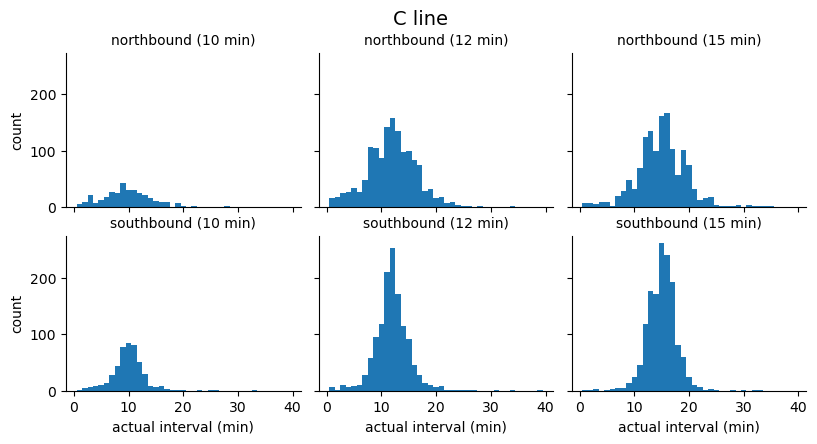

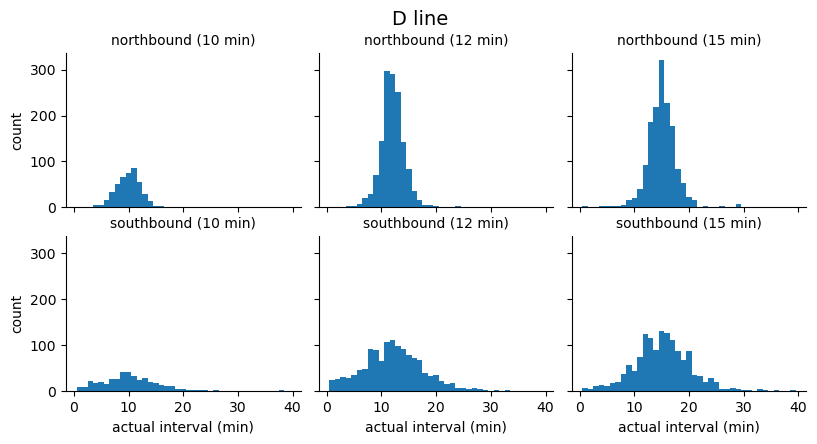

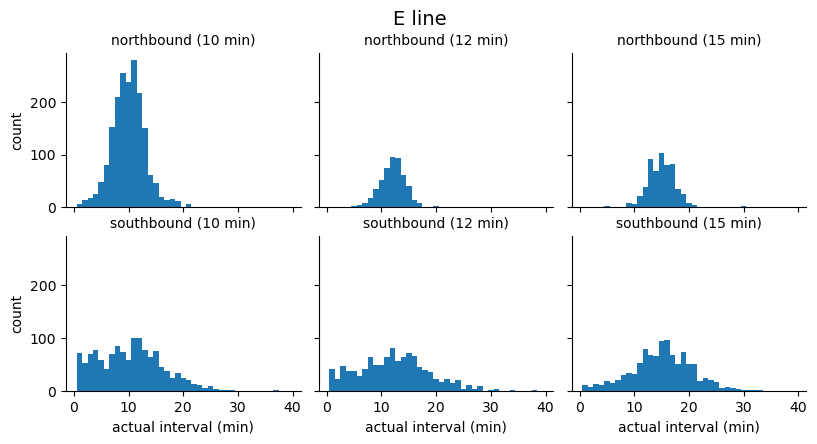

In [55]:
for route in ['C', 'D', 'E']:
    g = sns.FacetGrid(sequenced.query(f"route == '{route}'"),
                      row="direction", col="scheduled_interval")
    g.map(plt.hist, "actual_interval", bins=np.arange(40) + 0.5)
    g.set_titles('{row_name} ({col_name:.0f} min)')
    g.set_axis_labels('actual interval (min)', 'count')
    g.fig.set_size_inches(8, 4)
    g.fig.suptitle(f'{route} line', y=1.05, fontsize=14)

In [57]:
def simulate_wait_times(arrival_times,
                        rseed=8675309,  # Jenny's random seed
                        n_passengers=1000000):
    rand = np.random.RandomState(rseed)
    
    arrival_times = np.asarray(arrival_times)
    passenger_times = arrival_times.max() * rand.rand(n_passengers)

    # find the index of the next bus for each simulated passenger
    i = np.searchsorted(arrival_times, passenger_times, side='right')

    return arrival_times[i] - passenger_times

In [58]:
grouped = sequenced.groupby(['route', 'direction', 'scheduled_interval'])
sims = grouped['actual'].apply(simulate_wait_times)
sims.apply(lambda times: "{0:.1f} +/- {1:.1f}".format(times.mean(), times.std()))

route  direction   scheduled_interval
C      northbound  10.0                  7.0 +/- 5.9
                   12.0                  7.3 +/- 5.7
                   15.0                  8.3 +/- 5.6
       southbound  10.0                  5.9 +/- 4.7
                   12.0                  6.6 +/- 4.8
                   15.0                  7.8 +/- 4.8
D      northbound  10.0                  5.4 +/- 3.8
                   12.0                  6.2 +/- 3.8
                   15.0                  7.8 +/- 4.8
       southbound  10.0                  6.8 +/- 6.4
                   12.0                  7.4 +/- 5.3
                   15.0                  8.5 +/- 6.1
E      northbound  10.0                  5.5 +/- 3.6
                   12.0                  6.2 +/- 3.9
                   15.0                  7.8 +/- 4.9
       southbound  10.0                  7.0 +/- 5.3
                   12.0                  7.9 +/- 5.8
                   15.0                  8.7 +/- 6.4
Name: ac